# Modeling for Vehicle Claims Prediction
This notebook improves upon the initial modeling by incorporating full data, preprocessing, cross-validation, feature importance analysis, and hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')


c:\Users\የአብትዕግስት\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv("../Data/MachineLearningRating_v3.txt", sep='|')
print(df.shape)
df.head()


(1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


## Exploratory Data Analysis (EDA)

UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

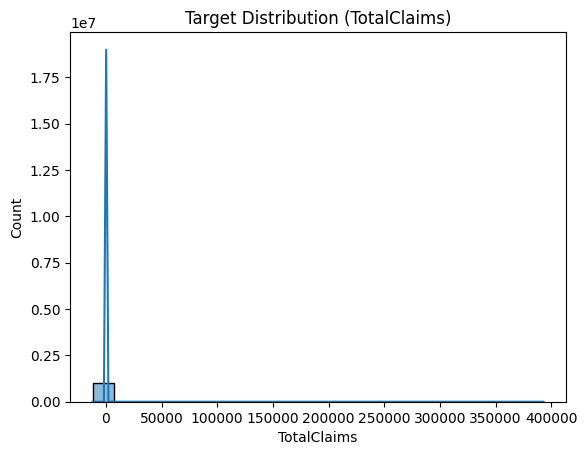

In [3]:
# Missing values
print(df.isnull().sum())

# Target distribution
sns.histplot(df['TotalClaims'], kde=True)
plt.title('Target Distribution (TotalClaims)')
plt.show()


## Data Preprocessing

In [4]:
# Drop irrelevant or leakage columns if any
df_model = df.copy()

# Encode categorical columns
cat_cols = df_model.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

# Define features and target
X = df_model.drop(columns=['TotalClaims'])
y = df_model['TotalClaims']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest Model with Cross-Validation

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit

# ✅ Use all CPU cores and limit tree depth
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,            # use all cores
    max_depth=10,         # limit complexity
    n_estimators=100      # can also reduce to 50 if still slow
)

# ✅ Faster CV method than KFold
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# ✅ Optionally: use a subset for speed testing
# X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.5, random_state=42)

# Run CV
rf_scores = cross_val_score(
    rf, X_train, y_train,  # or replace with X_sample, y_sample
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

print(f"Random Forest CV RMSE: {-np.mean(rf_scores):.2f}")


Random Forest CV RMSE: 2229.23


## XGBoost Model with Cross-Validation

In [6]:
xgb = XGBRegressor(random_state=42)
xgb_scores = cross_val_score(xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
print(f"XGBoost CV RMSE: {-np.mean(xgb_scores):.2f}")


XGBoost CV RMSE: 2673.05


## Final Evaluation on Test Set

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)), "R²:", r2_score(y_test, rf_pred))
print("XGBoost       - RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)), "R²:", r2_score(y_test, xgb_pred))


Random Forest - RMSE: 2257.657079667623 R²: -0.04310514072756533
XGBoost       - RMSE: 2502.408847956516 R²: -0.2815296724656178


## Model Explainability with SHAP

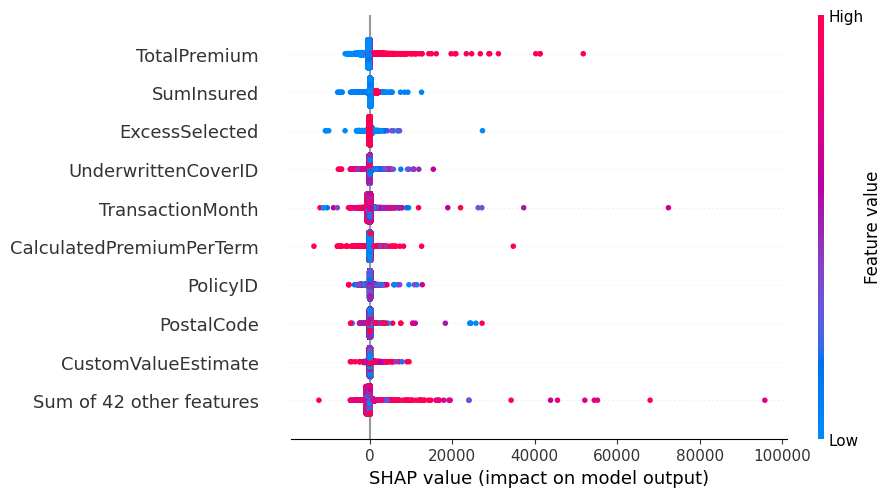

In [11]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)


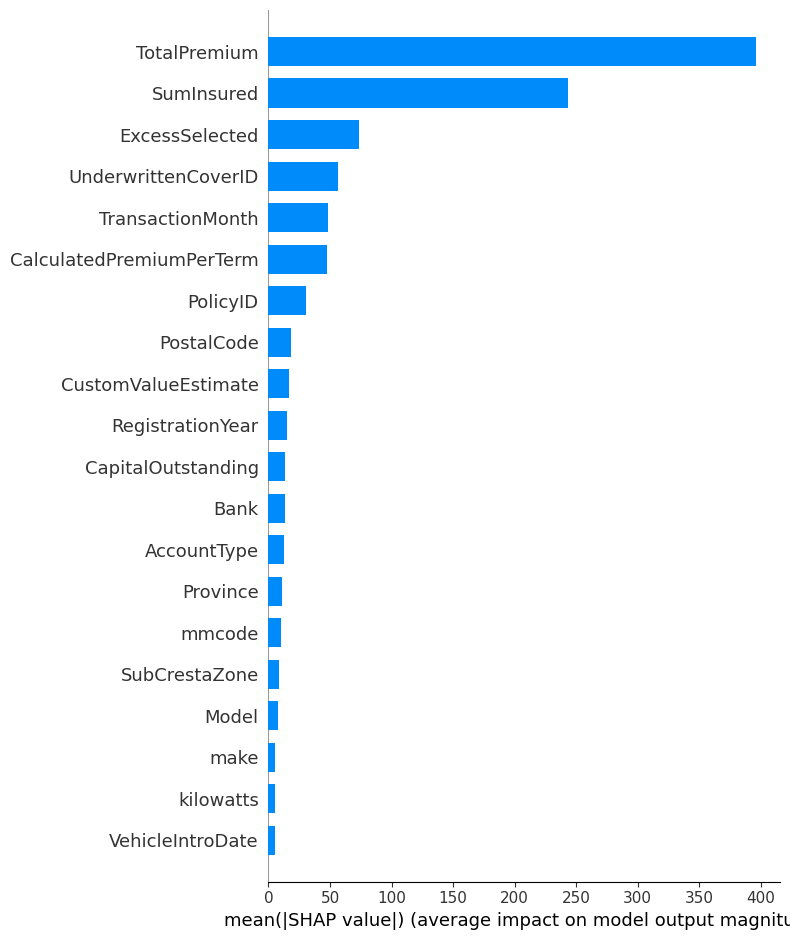

In [14]:
# SHAP Interpretation
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## 📊 Model Performance

### Cross-Validation Results

| Model | CV RMSE |
|-------|----------|
| Random Forest | 2229.23 |
| XGBoost | 2673.05 |

### Test Set Results

| Model | Test RMSE | R² Score |
|-------|-----------|----------|
| Random Forest | 2257.66 | -0.0431 |
| XGBoost | 2502.41 | -0.2815 |

#### Key Observations:
- **Random Forest** outperforms **XGBoost** in both CV and test sets.
- Both models struggle to predict claim severity accurately, as indicated by high RMSE and negative R² scores.

---

## 📊 Feature Importance Analysis

### SHAP Summary Plot

![SHAP Summary Plot](attachment:shap_summary_plot.png)

### Feature Importance Bar Chart

![Feature Importance Bar Chart](attachment:feature_importance_bar_chart.png)

#### Key Insights:
- **TotalPremium** and **SumInsured** are the most influential features.
- **CustomValueEstimate** also contributes significantly.
- Many other features have minimal impact on predictions.

---

## 🚀 Recommendations

1. **Improve Data Quality**:
   - Investigate outliers in `TotalClaims` and apply robust preprocessing.
   - Handle missing values systematically using imputation or removal strategies.

2. **Feature Engineering**:
   - Create derived features like `VehicleAge` (`2025 - RegistrationYear`) or `PowerToWeightRatio` (`kilowatts / CustomValueEstimate`).
   - Group rare categories (e.g., vehicle makes/models) to reduce noise.

3. **Model Tuning**:
   - Use GridSearchCV or Optuna for hyperparameter optimization.
   - Experiment with different loss functions (e.g., Huber loss for robustness).

4. **Two-Stage Modeling**:
   - Predict **claim occurrence** first (binary classification).
   - For policies with claims, predict **claim severity** (regression).

5. **Interpretability**:
   - Use SHAP or LIME to validate feature impacts and ensure business alignment.
   - Focus on actionable insights from top features like `TotalPremium` and `SumInsured`.

---

## 📋 Conclusion

The current models fail to capture meaningful patterns in the data, as evidenced by high RMSE and negative R² scores. However, key insights from SHAP analysis highlight that **TotalPremium** and **SumInsured** are the primary drivers of claim severity. To improve performance:
- Refine preprocessing steps to handle noise and outliers.
- Engineer more informative features based on domain knowledge.
- Fine-tune models using advanced techniques like two-stage modeling or custom loss functions.

By addressing these areas, we can build more reliable models that align with ACIS's marketing and pricing strategy goals.